### **Project Goal: Teaching a Machine to Write Names**

The objective remains the same: to build and train a neural network that learns the fundamental patterns of character sequences from a list of names. By learning these patterns, the model can then generate new, plausible names that follow the same stylistic rules. The core skill it learns is how to accurately predict the next character in a sequence, now with a clear understanding of where names begin and end.

---

### **Part 1: Understanding the Raw Material (Data Preparation)**

This phase is about translating the names from your text file into a numerical language the computer can process. Using `.` as a special token is central to this.

1.  **The Role of the Dot (`.`) Token:** The `.` character now serves a crucial dual purpose. It acts as both a **start-of-word** marker and an **end-of-word** marker. This explicitly tells the model, "A name is about to start," and, "The name you just saw is now complete."

2.  **Creating the Vocabulary:** The program scans all the names and compiles the vocabulary of all unique characters. The `.` character is now a vital member of this vocabulary, just as important as 'a', 'b', or 'c'.

3.  **Creating Translation Dictionaries:** To convert between letters and numbers, two dictionaries are created. One maps each character (including the `.`) to a unique integer (e.g., `.` -> 0, `a` -> 1, `b` -> 2). The other does the reverse, allowing us to translate the model's numerical output back into a readable name.

---

### **Part 2: Creating Superior Learning Exercises (Dataset Formulation)**

This is where using the `.` token dramatically improves the project. The model learns not just from the characters within the names, but also from the context of starting and ending.

1.  **Padding the Data:** Before creating the learning examples, every name in the source file is "padded" with `.` characters. If your context window is three, a name like "liam" is transformed into `...liam.`. This padding is the textbook from which the model will learn.

2.  **The Enhanced Sliding Window:** The program slides its three-character context window across this new, padded string to create much more informative input/output pairs.
    *   **Exercise 1 (Learning to Start):** The AI is given the context `...` (three dots) and is taught that the correct answer is `l`. By seeing thousands of these examples, it learns the statistical probability of which letters are most likely to *begin* a name.
    *   **Exercise 2:** The context slides forward. The AI is given `..l` and told the correct answer is `i`.
    *   **Exercise 3:** The context slides again. The AI is given `.li` and told the correct answer is `a`.
    *   **Exercise 4:** The context slides again. The AI is given `lia` and told the correct answer is `m`.
    *   **Exercise 5 (Learning to End):** The context slides a final time. The AI is given `iam` and taught that the correct answer is `.`. This is a critical lesson. The model explicitly learns which character sequences signify that a name is complete.

This method produces a far superior dataset. The model doesn't just learn "what follows 'ia'," it also learns "what follows the start of a word" and "what character combination means it's time to end the word."

---

### **Part 3: The Brain of the Operation (The Model Architecture)**

The internal structure of the AI remains the same. It is still a **Recurrent Neural Network (RNN)** perfectly suited for sequential data.

1.  **The Embedding Layer (The "Meaning" Layer):** Converts the integer for each character (including the one for `.`) into a rich numerical vector, allowing the model to learn deeper relationships between characters.
2.  **The RNN Layer (The "Memory" Layer):** Processes the sequence of three character vectors one by one, using its internal memory (hidden state) to understand the order and context of the sequence.
3.  **The Linear Layer (The "Decision" Layer):** Takes the RNN's final memory state (a summary of the sequence) and produces a score for every character in the vocabulary, indicating how likely each one is to be the next character.

---

### **Part 4: The Study Session (Model Training)**

The training process itself is mechanically identical, but the quality of the "lessons" is now much higher.

1.  **Guess, Measure, Learn:** The model is fed batches of the new, padded exercises.
2.  **Forward Pass:** It makes a prediction for each context.
3.  **Loss Calculation:** It measures how wrong its predictions were compared to the correct answers.
4.  **Backward Pass & Optimization:** It calculates which of its internal parameters were most responsible for any errors and the optimizer adjusts them slightly to improve future performance.

This cycle is repeated for many epochs. The model gets progressively better at predicting the next character, including when to start a name with a letter and when to finish a name with a `.`.

---

### **Part 5: The Creative Act (Generating New Names)**

The generation phase now becomes more natural and intelligent, directly benefiting from the use of the `.` token.

1.  **The Starting Signal:** To begin generating a new name, we don't start with an empty or zero-filled context. We give the model the explicit starting signal it was trained on: a context of three `.` characters.

2.  **Iterative Prediction:** The model takes this `...` context and predicts the most likely first letter (or rather, we sample from its predicted probabilities to ensure variety). Let's say it picks `e`.

3.  **Update and Repeat:** The generated sequence is now "e". The context is updated to `..e` and fed back into the model. The model now predicts the second character. Let's say it's `m`. The sequence is now "em", and the context updates to `.em`. This loop of **predict -> sample -> update** continues.

In [28]:
words = open('names.txt', 'r').read().splitlines()

In [29]:
len(words)

32033

In [30]:
vocab =''.join(words)


In [59]:
vocab =sorted(set(''.join(words)))
len(vocab)

26

In [32]:
i2s = {i+1:j for i,j in enumerate(vocab)}

In [33]:
s2i = {j:i+1 for i,j in enumerate(vocab)}

In [34]:
i2s[0] = '.'
s2i['.'] = 0
s2i

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [35]:
s2i[i2s[12]]

12

In [36]:
x= []
y= []
context_window = 3
context = [0] * context_window

for word in words:
    for char in  word:
        ix = s2i[char]
        x.append(context)
        y.append(ix)
        context = context[1:] + [ ix]

In [37]:
len(x)

196113

In [38]:
len(y)

196113

In [39]:
import torch

In [40]:
x = torch.tensor(x)
y = torch.tensor(y)
x.shape, y.shape

(torch.Size([196113, 3]), torch.Size([196113]))

In [120]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = MyDataset(x, y)
dataloader = DataLoader(dataset, batch_size=512*8, shuffle=True)

C:\Users\user\AppData\Local\Temp\ipykernel_9688\2731668160.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.long)
C:\Users\user\AppData\Local\Temp\ipykernel_9688\2731668160.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)


In [121]:
import torch
import torch.nn as nn

class MyTextModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super(MyTextModel, self).__init__()
        
        self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # print(x.shape)
        x = self.emb(x)
        # print(x.shape)
        out, hidden = self.rnn(x)
        # print(out.shape, hidden.shape)
        last_hidden = hidden[-1] 
        # print(last_hidden.shape)
        out = self.fc(last_hidden)  
        # print(out.shape)
        return out


In [128]:
torch.manual_seed(42)
MyModel = MyTextModel(27,4,4,27)

In [129]:
test,teach = next(iter(dataloader))

In [130]:
test.shape, teach.shape

(torch.Size([4096, 3]), torch.Size([4096]))

In [131]:
MyModel(test)

tensor([[ 0.0912,  0.4964,  0.7328,  ...,  0.6188, -0.2077,  0.4909],
        [ 0.4767,  0.4388,  0.7456,  ..., -0.1041,  0.2572, -0.3621],
        [ 0.0142,  0.3445,  0.6181,  ...,  0.5959, -0.0797,  0.4186],
        ...,
        [ 0.1082,  0.4468,  0.7269,  ..., -0.0623,  0.0661,  0.0975],
        [ 0.3659,  0.3559,  0.5481,  ...,  0.1498,  0.0232, -0.1049],
        [ 0.4058,  0.2281,  0.5571,  ..., -0.0886,  0.3898, -0.4599]],
       grad_fn=<AddmmBackward0>)

In [132]:
import torch.nn as nn
import torch.nn.functional as F

MyModel.train()
optimizer =  torch.optim.Adam(MyModel.parameters(), lr = 0.001)
criterion =  F.cross_entropy
counter = 0
lossi = [] ;stepi = []
for epoch in range(50):
    for feature, label in dataloader:
        predict = MyModel(feature)
        loss = criterion(predict, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
        stepi.append(counter)
        counter += 1

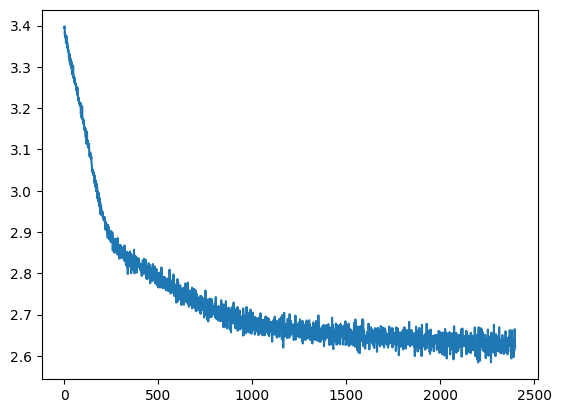

In [133]:
import matplotlib.pyplot as plt
plt.plot(stepi, lossi)

In [137]:
import torch
import torch.nn.functional as F

num_names_to_generate = 10
max_name_length = 5
context_window = 3   

print(f"Generating {num_names_to_generate} new names...\n")

MyModel.eval()
for i in range(num_names_to_generate):
    context = [0] * context_window
    generated_indices = []

    for _ in range(max_name_length):
        

        context_tensor = torch.tensor([context], dtype=torch.long)

        with torch.no_grad():
            prediction_logits = MyModel(context_tensor)
        probabilities = F.softmax(prediction_logits, dim=1)
        next_char_index = torch.multinomial(probabilities, num_samples=1).item()
        if next_char_index == 0:
            break
        generated_indices.append(next_char_index)
        context = context[1:] + [next_char_index]

    new_name = ''.join(i2s[index] for index in generated_indices)
    print(f"- {new_name}")

Generating 10 new names...

- anmit
- hiyem
- norev
- ziath
- taril
- hnthi
- raane
- uliad
- ektia
- sedas
